
Consider the following KdV equation:
$$\frac{\partial u}{∂t} + \frac{∂^3u}{∂x^3} + 6u\frac{∂u}{∂x} = 0, (x,t)∈[-4,4] × [-0.5,0.5]$$

## 1.Setup

In [51]:
# %%
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from math import *
import time
import copy
import pickle
import os

# %%
torch.set_default_tensor_type('torch.DoubleTensor')
plt.style.use('seaborn-white')

## 2.Hyperparameter

In [64]:
dimension = 2
input_width,layer_width = dimension, 35

repeat = 1  # Editable
epoch1, epoch2, epoch3 = 1, 1, 1  # Editable
lr = 1e-3  # Editable
data_size = 18000  # Editable
data_initial_size = 914  # Editable

left_boundary = -1
right_boundary = 1

# create directory to save results
if not os.path.exists('data/KdV3_transformation'):
    os.makedirs('data/KdV3_transformation')

# create directory to save temporary results
if not os.path.exists('temp/KdV3_transformation'):
    os.makedirs('temp/KdV3_transformation')

# create directory to save images
if not os.path.exists('images/KdV3_transformation'):
    os.makedirs('images/KdV3_transformation')

## 3.Neural Architecture

In [65]:
# %%
# activation function
def activation(x):
    return torch.sin(x)


# %%
# build ResNet with one blocks
class Net(torch.nn.Module):
    def __init__(self,input_width,layer_width):
        super(Net,self).__init__()
        self.layer1 = torch.nn.Linear(input_width, layer_width)
        self.layer2 = torch.nn.Linear(layer_width, layer_width)
        self.layer3 = torch.nn.Linear(layer_width, layer_width)
        self.layer4 = torch.nn.Linear(layer_width, layer_width)
        self.layer5 = torch.nn.Linear(layer_width, 1)
        self.initialize_weights()
    def forward(self,x):
        y = activation(self.layer1(x))
        y = activation(self.layer4(activation(self.layer3(activation(self.layer2(y)))))) # residual block 1
        output = self.layer5(y)
        return output
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
    def print_network(self):
        num_params = 0
        for param in self.parameters():
            num_params += param.numel()
        # print(self)
        print('Total number of parameters: %d' % num_params)

${\rm N}(\vec{x}) := {\rm A}_5({\sigma}{\rm A}_4(σ{\rm A}_3({σ}{\rm A}_2({σ}{\rm A}_{\rm 1}(\vec{x})))))$, where

${\rm A}_1: \mathbb{R^2}{→}\mathbb{R}^{\rm width}$, ${\rm A}_2: \mathbb{R}^{\rm width}{→}\mathbb{R}^{\rm width}$, ${\rm A}_3: \mathbb{R}^{\rm width}{→}\mathbb{R}^{\rm width}$, ${\rm A}_4: \mathbb{R}^{\rm width}{→}\mathbb{R}^{\rm width}$, ${\rm A}_5: \mathbb{R}^{\rm width}{→}\mathbb{R}$, 

note: there are `n` parameters need to be trained in total in ${\rm N}(x)$, where

$ {\rm n} = (2 ⋅ {\rm width} + {\rm width}) + 3({\rm width} ⋅ {\rm width} + {\rm width}) + ({\rm width} ⋅ 1 + 1) = 3 ⋅ {\rm width} ^2 + 7 ⋅ {\rm width} + 1$

(3921 for width equal to 35)

## 4.Training setup

### 4.1 Define the exact solution

$$[-4,4]{×}[-0.5,0.5]{\ni}(x, t) {↦} u(x, t) = 2({\rm log}f)_{xx} {∈} {\mathbb R}$$

where 

$f = 1 + e^{η_1} + e^{η_2} + e^{η_3} + e^{η_1+η_2+Α_{12}} + e^{η_2+η_3+Α_{23}} + e^{η_3+η_1+Α_{31}} + e^{η_1+η_2+η_3+Α_{12}+Α_{23}+Α_{31}}$, 

$η_i = k_ix -k_i^3t + η_i^{(0)}$, and 

$e^{Α_{ij}} = (\frac{k_i - k_j}{k_i+k_j})^2$

For initial conditions, the solution is used at $t=0$ and one set of values of the parameters are studied, namely:
$k_1 = 2, k_2=4, k_3=-6, η_1^{(0)}={\rm ln}\frac{3}{2}, η_2^{(0)}={\rm ln}\frac{3}{5}, η_2^{(0)}={\rm ln}\frac{1}{10}$


In [66]:
# defination of exact solution
def u_ex(X):
    x = X[:,0]
    t = X[:,1]
    # four values shown in the paper
    k1 = 2
    k2 = 4
    k3 = -6
    eta1 = log(3/2)
    eta2 = log(3/5)
    eta3 = log(1/10)

    etaMat1 = (k1*x - k1**3*t + eta1).reshape([x.size()[0], 1])
    etaMat2 = (k2*x - k2**3*t + eta2).reshape([x.size()[0], 1])
    etaMat3 = (k3*x - k3**3*t + eta3).reshape([x.size()[0], 1])
    c12 = ((k1 - k2)/(k1 + k2))**2
    c23 = ((k2 - k3)/(k2 + k3))**2
    c31 = ((k1 - k3)/(k1 + k3))**2

    f = 1.0 + torch.exp(etaMat1) + torch.exp(etaMat2) + torch.exp(etaMat3) + torch.exp(etaMat1) * torch.exp(etaMat2) * c12 + torch.exp(etaMat2) * torch.exp(etaMat3) * c23 + torch.exp(etaMat3) * torch.exp(etaMat1) * c31 + torch.exp(etaMat1) * torch.exp(etaMat2) * torch.exp(etaMat3) * c12 * c23 * c31

    df = k1*torch.exp(etaMat1) + k2*torch.exp(etaMat2) + k3*torch.exp(etaMat3) + (k1 + k2)*(torch.exp(etaMat1) * torch.exp(etaMat2) * c12) + (k2 + k3)*(torch.exp(etaMat2) * torch.exp(etaMat3) * c23) + (k3 + k1)*(torch.exp(etaMat3) * torch.exp(etaMat1) * c31) + (k1 + k2 + k3)*(torch.exp(etaMat1) * torch.exp(etaMat2) * torch.exp(etaMat3) * c12 * c23 * c31)

    ddf = (k1**2)*torch.exp(etaMat1) + (k2**2)*torch.exp(etaMat2) + (k3**2)*torch.exp(etaMat3) + ((k1 + k2)**2)*(torch.exp(etaMat1) * torch.exp(etaMat2) * c12) + ((k2 + k3)**2)*(torch.exp(etaMat2) * torch.exp(etaMat3) * c23) + ((k3 + k1)**2)*(torch.exp(etaMat3) * torch.exp(etaMat1) * c31) + ((k1 + k2 + k3)**2)*(torch.exp(etaMat1) * torch.exp(etaMat2) * torch.exp(etaMat3) * c12 * c23 * c31)

    y = 2 * (f * ddf - df**2) / (f**2)  # Use chains rule to get the second derivative of lnf in terms of x
    return y.reshape([X.size()[0], 1])

### 4.2 Define $u_0(x)$

$$[-4,4]{\ni}x {↦} u_0(x) = -12{\rm {sech}}^2(x) {∈} {\mathbb R}$$

In [67]:
def u_0x(X):
    x = X[:,0]
    t = X[:,1]
    return 12 * torch.square(torch.divide(1, torch.cosh(x))).reshape([X.size()[0], 1])

### 4.3 Define g(x,t)

#### 4.3.1 Define g_0(x, t)

<!-- $$ \{0,1\}×[0,1] \ni (x,t) ↦ g(x,t) = -{\frac{1}{2}}{\rm c}sech^2[{\frac{\sqrt {\rm c}}{2}}(x-{\rm c}t-{\rm a})] ∈ {\mathbb R}$$ -->

$$[-0.5,0.5]{\ni}t {↦}g_0(t) := u(-1,t) = 2({\rm log}f)_{xx} \mid_{x=-4} {∈} {\mathbb R}$$

where 

$f = 1 + e^{η_1} + e^{η_2} + e^{η_3} + e^{η_1+η_2+Α_{12}} + e^{η_2+η_3+Α_{23}} + e^{η_3+η_1+Α_{31}} + e^{η_1+η_2+η_3+Α_{12}+Α_{23}+Α_{31}}$, 

$η_i = -15k_i -k_i^3t + η_i^{(0)}$, and 

$e^{Α_{ij}} = (\frac{k_i - k_j}{k_i+k_j})^2$

For initial conditions, the solution is used at $t=0$ and two different sets of values of the parameters are studied, namely:
$k_1 = 2, k_2=4, k_3=-6, η_1^{(0)}={\rm ln}\frac{3}{2}, η_2^{(0)}={\rm ln}\frac{3}{5}, η_2^{(0)}={\rm ln}\frac{1}{10}$

In [68]:
def g_0x(X):
    x = torch.zeros([X.shape[0],1])[:,0]+left_boundary
    x.requires_grad = True
    t = X[:,1]
    # four values shown in the paper
    k1 = 2
    k2 = 4
    k3 = -6
    eta1 = log(3/2)
    eta2 = log(3/5)
    eta3 = log(1/10)

    etaMat1 = (k1*x - k1**3*t + eta1).reshape([x.size()[0], 1])
    etaMat2 = (k2*x - k2**3*t + eta2).reshape([x.size()[0], 1])
    etaMat3 = (k3*x - k3**3*t + eta3).reshape([x.size()[0], 1])
    c12 = ((k1 - k2)/(k1 + k2))**2
    c23 = ((k2 - k3)/(k2 + k3))**2
    c31 = ((k1 - k3)/(k1 + k3))**2

    f = 1.0 + torch.exp(etaMat1) + torch.exp(etaMat2) + torch.exp(etaMat3) + torch.exp(etaMat1) * torch.exp(etaMat2) * c12 + torch.exp(etaMat2) * torch.exp(etaMat3) * c23 + torch.exp(etaMat3) * torch.exp(etaMat1) * c31 + torch.exp(etaMat1) * torch.exp(etaMat2) * torch.exp(etaMat3) * c12 * c23 * c31

    df = k1*torch.exp(etaMat1) + k2*torch.exp(etaMat2) + k3*torch.exp(etaMat3) + (k1 + k2)*(torch.exp(etaMat1) * torch.exp(etaMat2) * c12) + (k2 + k3)*(torch.exp(etaMat2) * torch.exp(etaMat3) * c23) + (k3 + k1)*(torch.exp(etaMat3) * torch.exp(etaMat1) * c31) + (k1 + k2 + k3)*(torch.exp(etaMat1) * torch.exp(etaMat2) * torch.exp(etaMat3) * c12 * c23 * c31)

    ddf = (k1**2)*torch.exp(etaMat1) + (k2**2)*torch.exp(etaMat2) + (k3**2)*torch.exp(etaMat3) + ((k1 + k2)**2)*(torch.exp(etaMat1) * torch.exp(etaMat2) * c12) + ((k2 + k3)**2)*(torch.exp(etaMat2) * torch.exp(etaMat3) * c23) + ((k3 + k1)**2)*(torch.exp(etaMat3) * torch.exp(etaMat1) * c31) + ((k1 + k2 + k3)**2)*(torch.exp(etaMat1) * torch.exp(etaMat2) * torch.exp(etaMat3) * c12 * c23 * c31)

    y = 2 * (f * ddf - df**2) / (f**2)  # Use chains rule to get the second derivative of lnf in terms of x
    return y.reshape([X.size()[0], 1])

#### 4.3.2 Define g_1(x, t)

<!-- $$ \{0,1\}×[0,1] \ni (x,t) ↦ g(x,t) = -{\frac{1}{2}}{\rm c}sech^2[{\frac{\sqrt {\rm c}}{2}}(x-{\rm c}t-{\rm a})] ∈ {\mathbb R}$$ -->

$$[-0.5,0.5]{\ni}t {↦}g_0(t) := u(1,t) = 2({\rm log}f)_{xx} \mid_{x=4} {∈} {\mathbb R}$$

where 

$f = 1 + e^{η_1} + e^{η_2} + e^{η_3} + e^{η_1+η_2+Α_{12}} + e^{η_2+η_3+Α_{23}} + e^{η_3+η_1+Α_{31}} + e^{η_1+η_2+η_3+Α_{12}+Α_{23}+Α_{31}}$, 

$η_i = 15k_i -k_i^3t + η_i^{(0)}$, and 

$e^{Α_{ij}} = (\frac{k_i - k_j}{k_i+k_j})^2$

For initial conditions, the solution is used at $t=0$ and two different sets of values of the parameters are studied, namely:
$k_1 = 2, k_2=4, k_3=-6, η_1^{(0)}={\rm ln}\frac{3}{2}, η_2^{(0)}={\rm ln}\frac{3}{5}, η_2^{(0)}={\rm ln}\frac{1}{10}$

In [69]:
def g_1x(X):
    x = torch.zeros([X.shape[0],1])[:,0]+right_boundary
    x.requires_grad = True
    t = X[:,1]
    # four values shown in the paper
    k1 = 2
    k2 = 4
    k3 = -6
    eta1 = log(3/2)
    eta2 = log(3/5)
    eta3 = log(1/10)

    etaMat1 = (k1*x - k1**3*t + eta1).reshape([x.size()[0], 1])
    etaMat2 = (k2*x - k2**3*t + eta2).reshape([x.size()[0], 1])
    etaMat3 = (k3*x - k3**3*t + eta3).reshape([x.size()[0], 1])
    c12 = ((k1 - k2)/(k1 + k2))**2
    c23 = ((k2 - k3)/(k2 + k3))**2
    c31 = ((k1 - k3)/(k1 + k3))**2

    f = 1.0 + torch.exp(etaMat1) + torch.exp(etaMat2) + torch.exp(etaMat3) + torch.exp(etaMat1) * torch.exp(etaMat2) * c12 + torch.exp(etaMat2) * torch.exp(etaMat3) * c23 + torch.exp(etaMat3) * torch.exp(etaMat1) * c31 + torch.exp(etaMat1) * torch.exp(etaMat2) * torch.exp(etaMat3) * c12 * c23 * c31

    df = k1*torch.exp(etaMat1) + k2*torch.exp(etaMat2) + k3*torch.exp(etaMat3) + (k1 + k2)*(torch.exp(etaMat1) * torch.exp(etaMat2) * c12) + (k2 + k3)*(torch.exp(etaMat2) * torch.exp(etaMat3) * c23) + (k3 + k1)*(torch.exp(etaMat3) * torch.exp(etaMat1) * c31) + (k1 + k2 + k3)*(torch.exp(etaMat1) * torch.exp(etaMat2) * torch.exp(etaMat3) * c12 * c23 * c31)

    ddf = (k1**2)*torch.exp(etaMat1) + (k2**2)*torch.exp(etaMat2) + (k3**2)*torch.exp(etaMat3) + ((k1 + k2)**2)*(torch.exp(etaMat1) * torch.exp(etaMat2) * c12) + ((k2 + k3)**2)*(torch.exp(etaMat2) * torch.exp(etaMat3) * c23) + ((k3 + k1)**2)*(torch.exp(etaMat3) * torch.exp(etaMat1) * c31) + ((k1 + k2 + k3)**2)*(torch.exp(etaMat1) * torch.exp(etaMat2) * torch.exp(etaMat3) * c12 * c23 * c31)

    y = 2 * (f * ddf - df**2) / (f**2)  # Use chains rule to get the second derivative of lnf in terms of x
    return y.reshape([X.size()[0], 1])



### 4.4 Build the model (Train on the initial condition)

$[-4, 4] \ni x = {\vec X}[:,0]$

$[-0.5, 0.5] \ni t = {\vec X}[:,1]$

<!-- $${\rm model}({\vec x}) := {\rm N}({\vec x}) × x × (1-x) × t + x \times t × g(1, t) + (1-x) × t × g(0, t) + (1-t) × x × (1-x) × u_0(x, 0)$$ -->

$${\rm model_{vanilla}}({x, t}) := {\rm N}(x, t)$$

$${\rm model_{boundary-included}}({x,t}) := {\rm N}(x, t) ⋅ \frac{(4+x)}{8} ⋅ \frac{(4-x)}{8} + \frac{(4-x)}{8} ⋅ g_0(t)  + \frac{(4+x)}{8} ⋅ g_1(t)$$

$${\rm model_{initial-included}}({x,t}) := {\rm N}(x, t) ⋅ \frac{t^2}{t^2 + q} + \frac{q}{t^2 + q} ⋅ u_0(x)$$

In [70]:
def model1(X):
    term1 = net1(X)
    model_u_temp =  term1
    return model_u_temp.reshape([X.size()[0], 1])

def model2(X):
    x = X[:,0]
    t = X[:,1]
    x_temp = torch.add(x, -left_boundary).reshape([x.size()[0], 1]) / (right_boundary - left_boundary)
    x_minus = torch.subtract(right_boundary, x).reshape([x.size()[0], 1]) / (right_boundary - left_boundary)

    term1 = net2(X) * x_temp * x_minus
#     term1 = net(X) * x_temp * x_minus * t_temp
    term2 = x_minus * g_0x(X)
    term3 = x_temp * g_1x(X)
    
    model_u_temp =  term1 + term2 + term3
                   
    return model_u_temp.reshape([x.size()[0], 1])

def model3(X):
    q = 10e-5
    x = X[:,0]
    t = torch.square(X[:,1].reshape([x.size()[0], 1]))
    # t = X[:,1].reshape([x.size()[0], 1])
    factor1 = t / (t + q)
    # print(factor1)
    factor2 = q / (t + q)
    # print(factor2)

    term1 = net3(X) * factor1
    term2 = factor2 * u_0x(X)
    
    model_u_temp =  term1 + term2
                   
    return model_u_temp.reshape([x.size()[0], 1])

### 4.5 Generate sample

#### 4.5.1 $ν_1$ generator

Generate random points $(x_n, t_n)$ from $[-4,4] × [-0.5,0.5]$

In [71]:
# generate points by random
def generate_sample_one(data_size):
    sample_temp = torch.rand(data_size, dimension)
    sample_temp[:,0] = sample_temp[:,0] * (right_boundary - left_boundary) - (right_boundary - left_boundary) / 2
    sample_temp[:,1] = sample_temp[:,1] - 0.5
    sample_temp.requires_grad = True
    return sample_temp

#### 4.5.2 $ν_2$ generator

Generate random points $(x_n, t_n)$ from $\{-4,4\} × [-0.5,0.5]$

In [72]:
def generate_sample_two(data_initial_size):
    sample_temp = torch.rand(data_initial_size, dimension)
    middle = int(data_initial_size/2)
    sample_temp[:middle, 0] = left_boundary
    sample_temp[middle:, 0] = right_boundary
    sample_temp[:,1] = sample_temp[:,1] - 0.5
    sample_temp.requires_grad = True
    return sample_temp

#### 4.5.3 $ν_3$ generator

Generate random points $x_n$ from $[-4,4]$

In [73]:
def generate_sample_three(data_initial_size):
    sample_temp = torch.rand(data_initial_size, dimension)
    sample_temp[:,1] = 0.0
    sample_temp[:,0] = sample_temp[:,0] * (right_boundary - left_boundary) - (right_boundary - left_boundary) / 2
    sample_temp.requires_grad = True
    return sample_temp

### 4.6 Define Loss function 
**(Penalty term: Residual)**

$${\rm Loss_1}(û) = \lVert{\frac{∂û}{∂t}} + {\frac{∂^3û}{∂x^3}} + 6u{\frac{∂û}{∂x}}\rVert^2_{[-4,4]{×}{[-0.5,0.5]},{ν_1}} + \lVert û-g(x) \rVert^2_{{\{-5, 5\}}\times[-0.4,0.4], ν_2} + \lVert û-u_0(x)\rVert^2_{[-4,4], ν_3}$$

**(Penalty term: Residual + initial condition)**

$${\rm Loss_2}(û) = \lVert{\frac{∂û}{∂t}} + {\frac{∂^3û}{∂x^3}} + 6u{\frac{∂û}{∂x}}\rVert^2_{[-4,4]{×}{[-0.5,0.5]},{ν_1}} + \lVert û-u_0(x)\rVert^2_{[-4,4], ν_3}$$

**(Penalty term: Residual + boundary condition)**

$${\rm Loss_3}(û) = \lVert{\frac{∂û}{∂t}} + {\frac{∂^3û}{∂x^3}} + 6u{\frac{∂û}{∂x}}\rVert^2_{[-4,4]{×}{[-0.5,0.5]},{ν_1}} + \lVert û-g(x) \rVert^2_{{\{-4, 4\}}\times[-0.5,0.5], ν_2} $$

In [74]:
# %%
# loss function to PINN by auto differential
def loss_function1(x1, x2, x3):
    # first term
    u_hat = model1(x1)
    grad_u_hat = torch.autograd.grad(outputs = u_hat, inputs = x1, grad_outputs = torch.ones(u_hat.shape), create_graph = True) # dx and dt
    dx = grad_u_hat[0][:, 0].reshape([len(grad_u_hat[0]), 1])  # dx
    dt = grad_u_hat[0][:, 1].reshape([len(grad_u_hat[0]), 1])  # dt
    dxx = torch.autograd.grad(outputs = dx, inputs = x1, grad_outputs = torch.ones(dx.shape), create_graph = True)[0][:,0].reshape([len(grad_u_hat[0]), 1])  # dxx
    dxxx = torch.autograd.grad(outputs = dxx, inputs = x1, grad_outputs = torch.ones(dxx.shape), create_graph = True)[0][:,0].reshape([len(grad_u_hat[0]), 1])  # dxxx
    loss = torch.sum((dt + dxxx + 6 * u_hat * dx)**2) / len(x1)

    bias = torch.square(torch.mean(dt + dxxx + 6 * u_hat * dx))
    variance = torch.mean(torch.square(dt + dxxx + 6 * u_hat * dx - torch.mean(dt + dxxx + 6 * u_hat * dx)))

    # print("mean of dt: ", torch.mean(dt).item())
    # print("mean of dxxx: ", torch.mean(dxxx).item())
    # print("mean of 6 * u_hat * dx: ", torch.mean(6 * u_hat * dx).item())
    # print("bias: ", bias.item())
    # print("variance: ", variance.item())
    
    # #second term
    u_hat2 = model1(x2)
    middle = int(data_initial_size/2)
    gx0 = g_0x(x2)[:middle]
    gx1 = g_1x(x2)[middle:]
    loss2 = torch.sum((u_hat2[:middle] - gx0)**2) / len(x2) + torch.sum((u_hat2[middle:] - gx1)**2) / len(x2)

    # third term
    u_hat3 = model1(x3)
    u0 = u_0x(x3)
    loss3 = torch.sum((u_hat3 - u0) **2) / len(x3)

    # print('loss1: ', loss.item(), 'loss2: ', loss2.item(), 'loss3: ', loss3.item())

    return loss + loss2 + loss3, bias, variance


def loss_function2(x1, x2, x3):
    # first term
    u_hat = model2(x1)
    grad_u_hat = torch.autograd.grad(outputs = u_hat, inputs = x1, grad_outputs = torch.ones(u_hat.shape), create_graph = True) # dx and dt
    dx = grad_u_hat[0][:, 0].reshape([len(grad_u_hat[0]), 1])  # dx
    dt = grad_u_hat[0][:, 1].reshape([len(grad_u_hat[0]), 1])  # dt
    dxx = torch.autograd.grad(outputs = dx, inputs = x1, grad_outputs = torch.ones(dx.shape), create_graph = True)[0][:,0].reshape([len(grad_u_hat[0]), 1])  # dxx
    dxxx = torch.autograd.grad(outputs = dxx, inputs = x1, grad_outputs = torch.ones(dxx.shape), create_graph = True)[0][:,0].reshape([len(grad_u_hat[0]), 1])  # dxxx
    loss = torch.sum((dt + dxxx + 6 * u_hat * dx)**2) / len(x1)

    bias = torch.square(torch.mean(dt + dxxx + 6 * u_hat * dx))
    variance = torch.mean(torch.square(dt + dxxx + 6 * u_hat * dx - torch.mean(dt + dxxx + 6 * u_hat * dx)))

    # print("mean of dt: ", torch.mean(dt).item())
    # print("mean of dxxx: ", torch.mean(dxxx).item())
    # print("mean of 6 * u_hat * dx: ", torch.mean(6 * u_hat * dx).item())
    # print("bias: ", bias.item())
    # print("variance: ", variance.item())
    
    # #second term
    # u_hat2 = model(x2)
    # gx = g_x(x2)
    # loss2 = torch.sum((u_hat2 - gx)**2) / len(x2)

    # third term
    u_hat3 = model2(x3)
    u0 = u_0x(x3)
    loss3 = torch.sum((u_hat3 - u0) **2) / len(x3)

    # print('loss1: ', loss.item(), 'loss3: ', loss3.item())

    return loss + loss3, bias, variance


def loss_function3(x1, x2, x3):
    # first term
    u_hat = model3(x1)
    grad_u_hat = torch.autograd.grad(outputs = u_hat, inputs = x1, grad_outputs = torch.ones(u_hat.shape), create_graph = True) # dx and dt
    dx = grad_u_hat[0][:, 0].reshape([len(grad_u_hat[0]), 1])  # dx
    dt = grad_u_hat[0][:, 1].reshape([len(grad_u_hat[0]), 1])  # dt
    dxx = torch.autograd.grad(outputs = dx, inputs = x1, grad_outputs = torch.ones(dx.shape), create_graph = True)[0][:,0].reshape([len(grad_u_hat[0]), 1])  # dxx
    dxxx = torch.autograd.grad(outputs = dxx, inputs = x1, grad_outputs = torch.ones(dxx.shape), create_graph = True)[0][:,0].reshape([len(grad_u_hat[0]), 1])  # dxxx
    loss = torch.sum((dt + dxxx + 6 * u_hat * dx)**2) / len(x1)

    bias = torch.square(torch.mean(dt + dxxx + 6 * u_hat * dx))
    variance = torch.mean(torch.square(dt + dxxx + 6 * u_hat * dx - torch.mean(dt + dxxx + 6 * u_hat * dx)))

    # print("mean of dt: ", torch.mean(dt).item())
    # print("mean of dxxx: ", torch.mean(dxxx).item())
    # print("mean of 6 * u_hat * dx: ", torch.mean(6 * u_hat * dx).item())
    # print("bias: ", bias.item())
    # print("variance: ", variance.item())
    
    # #second term
    u_hat2 = model3(x2)
    middle = int(data_initial_size/2)
    gx0 = g_0x(x2)[:middle]
    gx1 = g_1x(x2)[middle:]
    loss2 = torch.sum((u_hat2[:middle] - gx0)**2) / len(x2) + torch.sum((u_hat2[middle:] - gx1)**2) / len(x2)

    # third term
    # u_hat3 = model(x3)
    # u0 = u_0x(x3)
    # loss3 = torch.sum((u_hat3 - u0) **2) / len(x3)

    # print('loss1: ', loss.item(), 'loss2: ', loss2.item())

    return loss + loss2, bias, variance

### 4.7 Define Fractional Error

$${\rm error} = \frac{\lVert \hat u - u \lVert _2^2}{\lVert u \lVert_2^2}$$

In [75]:
def cal_error1(x):
    u_hat = model1(x)
    u = u_ex(x)
    upper = torch.square((u_hat - u).norm(2))
    lower = torch.square(u.norm(2))
    return torch.divide(upper, lower)

def cal_error2(x):
    u_hat = model2(x)
    u = u_ex(x)
    upper = torch.square((u_hat - u).norm(2))
    lower = torch.square(u.norm(2))
    return torch.divide(upper, lower)

def cal_error3(x):
    u_hat = model3(x)
    u = u_ex(x)
    upper = torch.square((u_hat - u).norm(2))
    lower = torch.square(u.norm(2))
    return torch.divide(upper, lower)

## 5.Doing the training

### Generating training data and test data

In [76]:
x = generate_sample_one(data_size)
x2 = generate_sample_two(data_initial_size) 
x3 = generate_sample_three(data_initial_size)

# Testing data
test_data = torch.zeros((321, 321, 2))
for i in range(0, 321):
  x_test = i / (320 / (right_boundary - left_boundary)) - (right_boundary - left_boundary) / 2
  # x_test = i / 40 - 4
  for j in range(321):
    t_test = j / 320 - 0.5
    test_data[i][j][0] = x_test
    test_data[i][j][1] = t_test
test_data = torch.reshape(test_data, (321*321, 2))

### Training

In [15]:
# %%
loss1_all = []
error1_all = []
u_hat_1_all = []
bias1_all = []
variance1_all = []
for t in range(repeat):
  print("Time: ", t+1, "/{}".format(repeat))

  net1 = Net(input_width,layer_width)
  optimizer1 = optim.Adam(net1.parameters(), lr=lr)

  loss_record1 = np.zeros(epoch1)
  error_record1 = np.zeros(epoch1)
  bias_record1 = np.zeros(epoch1)
  variance_record1 = np.zeros(epoch1)

  time_start = time.time()
  for i in range(1, epoch1+1):
      optimizer1.zero_grad()
      loss1, bias1, variance1 = loss_function1(x, x2, x3)
      error1 = cal_error1(test_data)
      loss_record1[i-1] = float(loss1)
      error_record1[i-1] = float(error1)
      bias_record1[i-1] = float(bias1)
      variance_record1[i-1] = float(variance1)
      loss1.backward()
      optimizer1.step() 
      torch.cuda.empty_cache() # clear memory
      if i % 2000 == 0 or i == 1:
        print("current epoch: ", i)
        print("current loss: ", loss1.detach())
        print("current error: ", error1.detach())
      
  time_end = time.time()
  u_hat_1_all.append(model1(test_data).detach().numpy())
  loss1_all.append(loss_record1)
  error1_all.append(error_record1)
  bias1_all.append(bias_record1)
  variance1_all.append(variance_record1)
  print('total time is: ', time_end-time_start, 'seconds')

# save loss1_all, error1_all, u_hat_1_all using pickle
with open('data/KdV3_transformation/KdV3_loss1_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch1, lr, layer_width), 'wb') as f:
  pickle.dump(loss1_all, f)

with open('data/KdV3_transformation/KdV3_error1_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch1, lr, layer_width), 'wb') as f:
  pickle.dump(error1_all, f)

with open('data/KdV3_transformation/KdV3_u_hat_1_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch1, lr, layer_width), 'wb') as f:
  pickle.dump(u_hat_1_all, f)

with open('data/KdV3_transformation/KdV3_bias1_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch1, lr, layer_width), 'wb') as f:
  pickle.dump(bias1_all, f)

with open('data/KdV3_transformation/KdV3_variance1_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch1, lr, layer_width), 'wb') as f:
  pickle.dump(variance1_all, f)

Time:  1 /1
current epoch:  1
current loss:  tensor(34.8029)
current error:  tensor(1.1548)
total time is:  0.9417071342468262 seconds


In [16]:
loss2_all = []
error2_all = []
u_hat_2_all = []
bias2_all = []
variance2_all = []
for t in range(repeat):
  print("Time: ", t+1, "/{}".format(repeat))

  net2 = Net(input_width,layer_width)
  optimizer2 = optim.Adam(net2.parameters(), lr=lr)

  loss_record2 = np.zeros(epoch2)
  error_record2 = np.zeros(epoch2)
  bias2_record2 = np.zeros(epoch2)
  variance2_record2 = np.zeros(epoch2)

  time_start = time.time()
  for i in range(1, epoch2+1):
      optimizer2.zero_grad()
      loss2, bias2, variance2 = loss_function2(x, x2, x3)
      error2 = cal_error2(test_data)
      loss_record2[i-1] = float(loss2)
      error_record2[i-1] = float(error2)
      bias2_record2[i-1] = float(bias2)
      variance2_record2[i-1] = float(variance2)
      loss2.backward()
      optimizer2.step() 
      torch.cuda.empty_cache() # clear memory
      if i % 2000 == 0 or i == 1:
        print("current epoch: ", i)
        print("current loss: ", loss2.detach())
        print("current error: ", error2.detach())
      
  time_end = time.time()
  u_hat_2_all.append(model2(test_data).detach().numpy())
  loss2_all.append(loss_record2)
  error2_all.append(error_record2)
  bias2_all.append(bias2_record2)
  variance2_all.append(variance2_record2)
  print('total time is: ', time_end-time_start, 'seconds')

# save loss2_all, error2_all, u_hat_2_all using pickle
with open('data/KdV3_transformation/KdV3_loss2_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch2, lr, layer_width), 'wb') as f:
  pickle.dump(loss2_all, f)

with open('data/KdV3_transformation/KdV3_error2_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch2, lr, layer_width), 'wb') as f:
  pickle.dump(error2_all, f)

with open('data/KdV3_transformation/KdV3_u_hat_2_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch2, lr, layer_width), 'wb') as f:
  pickle.dump(u_hat_2_all, f)

with open('data/KdV3_transformation/KdV3_bias2_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch2, lr, layer_width), 'wb') as f:
  pickle.dump(bias2_all, f)

with open('data/KdV3_transformation/KdV3_variance2_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch2, lr, layer_width), 'wb') as f:
  pickle.dump(variance2_all, f)

Time:  1 /1
current epoch:  1
current loss:  tensor(26563.8073)
current error:  tensor(1.1099)
total time is:  1.1240217685699463 seconds


In [17]:
loss3_all = []
error3_all = []
u_hat_3_all = []
bias3_all = []
variance3_all = []
for t in range(repeat):
  print("Time: ", t+1, "/{}".format(repeat))

  net3 = Net(input_width,layer_width)
  optimizer3 = optim.Adam(net3.parameters(), lr=lr)

  loss_record3 = np.zeros(epoch3)
  error_record3 = np.zeros(epoch3)
  bias3_record3 = np.zeros(epoch3)
  variance3_record3 = np.zeros(epoch3)

  time_start = time.time()
  for i in range(1, epoch3+1):
      optimizer3.zero_grad()
      loss3, bias3, variance3 = loss_function3(x, x2, x3)
      error3 = cal_error3(test_data)
      loss_record3[i-1] = float(loss3)
      error_record3[i-1] = float(error3)
      bias3_record3[i-1] = float(bias3)
      variance3_record3[i-1] = float(variance3)
      loss3.backward()
      optimizer3.step() 
      torch.cuda.empty_cache() # clear memory
      if i % 2000 == 0 or i == 1:
        print("current epoch: ", i)
        print("current loss: ", loss3.detach())
        print("current error: ", error3.detach())
      
  time_end = time.time()
  u_hat_3_all.append(model3(test_data).detach().numpy())
  loss3_all.append(loss_record3)
  error3_all.append(error_record3)
  bias3_all.append(bias3_record3)
  variance3_all.append(variance3_record3)
  print('total time is: ', time_end-time_start, 'seconds')

# save loss3_all, error3_all, u_hat_3_all using pickle
with open('data/KdV3_transformation/KdV3_loss3_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch3, lr, layer_width), 'wb') as f:
  pickle.dump(loss3_all, f)

with open('data/KdV3_transformation/KdV3_error3_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch3, lr, layer_width), 'wb') as f:
  pickle.dump(error3_all, f)

with open('data/KdV3_transformation/KdV3_u_hat_3_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch3, lr, layer_width), 'wb') as f:
  pickle.dump(u_hat_3_all, f)

with open('data/KdV3_transformation/KdV3_bias3_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch3, lr, layer_width), 'wb') as f:
  pickle.dump(bias3_all, f)

with open('data/KdV3_transformation/KdV3_variance3_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch3, lr, layer_width), 'wb') as f:
  pickle.dump(variance3_all, f)

Time:  1 /1
current epoch:  1
current loss:  tensor(1919.9088)
current error:  tensor(0.9532)
total time is:  0.8771162033081055 seconds


In [18]:
data_size = 18000
data_initial_size = 918
epoch1, epoch2, epoch3 = 40000, 40000, 40000
lr = 0.001
repeat = 3

# # load loss1_all, error1_all, u_hat_1_all using pickle
with open('src/data/KdV3_transformation/KdV3_loss1_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch1, lr, layer_width), 'rb') as f:
    loss1_all = pickle.load(f)

with open('src/data/KdV3_transformation/KdV3_error1_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch1, lr, layer_width), 'rb') as f:
    error1_all = pickle.load(f)

with open('src/data/KdV3_transformation/KdV3_u_hat_1_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch1, lr, layer_width), 'rb') as f:
    u_hat_1_all = pickle.load(f)

# load loss2_all, error2_all, u_hat_2_all using pickle
with open('src/data/KdV3_transformation/KdV3_loss2_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch2, lr, layer_width), 'rb') as f:
    loss2_all = pickle.load(f)

with open('src/data/KdV3_transformation/KdV3_error2_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch2, lr, layer_width), 'rb') as f:
    error2_all = pickle.load(f)

with open('src/data/KdV3_transformation/KdV3_u_hat_2_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch2, lr, layer_width), 'rb') as f:
    u_hat_2_all = pickle.load(f)

# load loss3_all, error3_all, u_hat_3_all using pickle
with open('src/data/KdV3_transformation/KdV3_loss3_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch3, lr, layer_width), 'rb') as f:
    loss3_all = pickle.load(f)

with open('src/data/KdV3_transformation/KdV3_error3_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch3, lr, layer_width), 'rb') as f:
    error3_all = pickle.load(f)

with open('src/data/KdV3_transformation/KdV3_u_hat_3_all_{}_{}_{}_{}.pkl'.format(data_size+data_initial_size*2, epoch3, lr, layer_width), 'rb') as f:
    u_hat_3_all = pickle.load(f)

## 6.Plotting the output

### Plot the Exmperical Loss & Fractional Error

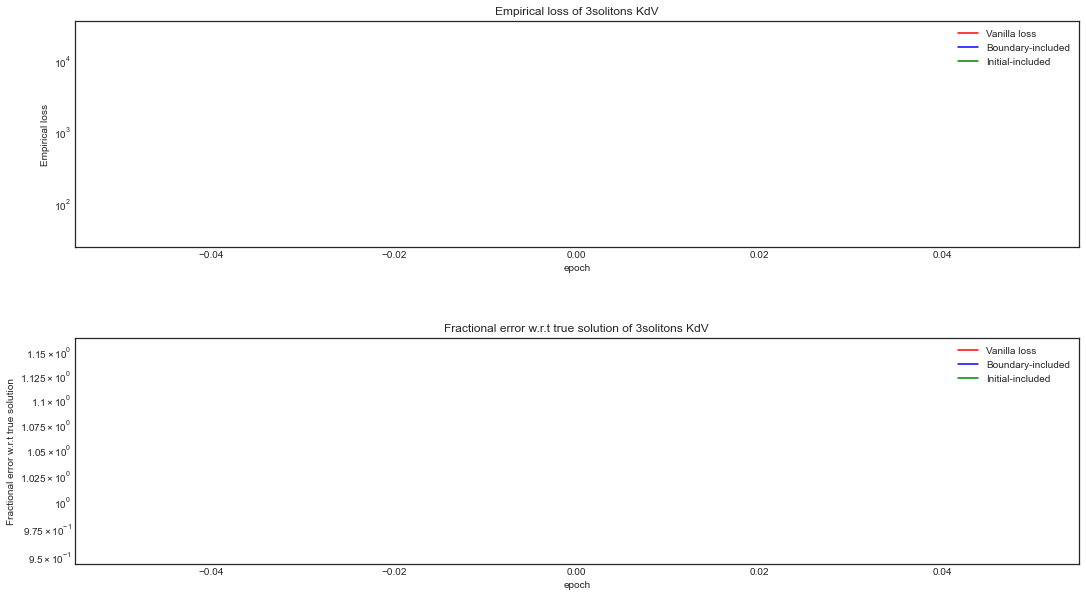

In [19]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(10)
fig.set_figwidth(18)

ax = fig.add_subplot(2, 1, 1)
for i in range(repeat):
    ax.plot(loss1_all[i], label = 'Vanilla loss' if i==0 else None, color = 'red')
    ax.plot(loss2_all[i], label = 'Boundary-included' if i==0 else None, color = 'blue')
    ax.plot(loss3_all[i], label = 'Initial-included' if i==0 else None, color = 'green')
ax.set_xlabel('epoch')
ax.set_ylabel('Empirical loss')
ax.set_title("Empirical loss of 3solitons KdV")
ax.set_yscale("log")
ax.legend()

ax = fig.add_subplot(2, 1, 2)
for i in range(repeat):
    ax.plot(error1_all[i], label = 'Vanilla loss' if i==0 else None, color = 'red')
    ax.plot(error2_all[i], label = 'Boundary-included' if i==0 else None, color = 'blue')
    ax.plot(error3_all[i], label = 'Initial-included' if i==0 else None, color = 'green')
ax.set_xlabel('epoch')
ax.set_ylabel('Fractional error w.r.t true solution')
ax.set_title("Fractional error w.r.t true solution of 3solitons KdV")
ax.set_yscale("log")
ax.legend()

# save the figure
fig.savefig('images/KdV3_transformation/KdV3_loss_error_{}_{}_{}_{}.png'.format(data_size+data_initial_size*2, epoch3, lr, layer_width))

### Plot the variance of the loss and error

In [20]:
# calculate the variance of loss1_all and error1_all in column direction
var_loss1_all = np.array(loss1_all).var(axis=0)
var_error1_all = np.array(error1_all).var(axis=0)
var_bias1_all = np.array(bias1_all).var(axis=0)
var_variance1_all = np.array(variance1_all).var(axis=0)

# calculate the variance of loss2_all and error2_all in column direction
var_loss2_all = np.array(loss2_all).var(axis=0)
var_error2_all = np.array(error2_all).var(axis=0)
var_bias2_all = np.array(bias2_all).var(axis=0)
var_variance2_all = np.array(variance2_all).var(axis=0)

# calculate the variance of loss3_all and error3_all in column direction
var_loss3_all = np.array(loss3_all).var(axis=0)
var_error3_all = np.array(error3_all).var(axis=0)
var_bias3_all = np.array(bias3_all).var(axis=0)
var_variance3_all = np.array(variance3_all).var(axis=0)

# Plot all the variance of loss and error
# fig = plt.figure()
# fig.subplots_adjust(hspace=0.4, wspace=0.4)
# fig.set_figheight(10)
# fig.set_figwidth(18)

# ax = fig.add_subplot(2, 1, 1)
# ax.plot(var_loss1_all, label = 'Vanilla loss, epoch={}, bulk={}, initial={}, boundary={}'.format(epoch1, data_size, data_size/2, data_size/2), color = 'red')
# ax.plot(var_loss2_all, label = 'Train on Initial, epoch={}, bulk={}, initial={}'.format(epoch2, data_size, data_size/2), color = 'blue')
# ax.plot(var_loss3_all, label = 'Train on boundary, epoch={}, bulk={}, boundary={}'.format(epoch3, data_size, data_size/2), color = 'green')
# ax.set_xlabel('epoch')
# ax.set_ylabel('Variance of empirical loss')
# ax.set_title("Variance of empirical loss of 3solitons KdV")
# ax.set_yscale("log")
# ax.legend()

# ax = fig.add_subplot(2, 1, 2)
# ax.plot(var_error1_all, label = 'Vanilla loss, epoch={}, bulk={}, initial={}, boundary={}'.format(epoch1, data_size, data_size/2, data_size/2), color = 'red')
# ax.plot(var_error2_all, label = 'Train on Initial, epoch={}, bulk={}, initial={}'.format(epoch2, data_size, data_size/2), color = 'blue')
# ax.plot(var_error3_all, label = 'Train on boundary, epoch={}, bulk={}, boundary={}'.format(epoch3, data_size, data_size/2), color = 'green')
# ax.set_xlabel('epoch')
# ax.set_ylabel('Variance of fractional error w.r.t true solution')
# ax.set_title("Variance of fractional error w.r.t true solution of 3solitons KdV")
# ax.set_yscale("log")
# ax.legend()

# # save the figure
# fig.savefig('images/KdV3_transformation/KdV3_loss_error_var_{}_{}_{}_{}.png'.format(data_size*2, epoch3, lr, layer_width))

### Plot the average of the loss and error

In [21]:
# calculate the mean of loss1_all and error1_all in column direction
mean_loss1_all = np.array(loss1_all).mean(axis=0)
mean_error1_all = np.array(error1_all).mean(axis=0)
mean_bias1_all = np.array(bias1_all).mean(axis=0)
mean_variance1_all = np.array(variance1_all).mean(axis=0)

# calculate the mean of loss2_all and error2_all in column direction
mean_loss2_all = np.array(loss2_all).mean(axis=0)
mean_error2_all = np.array(error2_all).mean(axis=0)
mean_bias2_all = np.array(bias2_all).mean(axis=0)
mean_variance2_all = np.array(variance2_all).mean(axis=0)

# calculate the mean of loss3_all and error3_all in column direction
mean_loss3_all = np.array(loss3_all).mean(axis=0)
mean_error3_all = np.array(error3_all).mean(axis=0)
mean_bias3_all = np.array(bias3_all).mean(axis=0)
mean_variance3_all = np.array(variance3_all).mean(axis=0)

# Plot all the mean of loss and error
# fig = plt.figure()
# fig.subplots_adjust(hspace=0.4, wspace=0.4)
# fig.set_figheight(10)
# fig.set_figwidth(18)

# ax = fig.add_subplot(2, 1, 1)
# ax.plot(mean_loss1_all, label = 'Vanilla loss, epoch={}, bulk={}, initial={}, boundary={}'.format(epoch1, data_size, data_size/2, data_size/2), color = 'red')
# ax.plot(mean_loss2_all, label = 'Train on Initial, epoch={}, bulk={}, initial={}'.format(epoch2, data_size, data_size/2), color = 'blue')
# ax.plot(mean_loss3_all, label = 'Train on boundary, epoch={}, bulk={}, boundary={}'.format(epoch3, data_size, data_size/2), color = 'green')
# ax.set_xlabel('epoch')
# ax.set_ylabel('Mean of empirical loss')
# ax.set_title("Mean of empirical loss of 3solitons KdV")
# ax.set_yscale("log")
# ax.legend()

# ax = fig.add_subplot(2, 1, 2)
# ax.plot(mean_error1_all, label = 'Vanilla loss, epoch={}, bulk={}, initial={}, boundary={}'.format(epoch1, data_size, data_size/2, data_size/2), color = 'red')
# ax.plot(mean_error2_all, label = 'Train on Initial, epoch={}, bulk={}, initial={}'.format(epoch2, data_size, data_size/2), color = 'blue')
# ax.plot(mean_error3_all, label = 'Train on boundary, epoch={}, bulk={}, boundary={}'.format(epoch3, data_size, data_size/2), color = 'green')
# ax.set_xlabel('epoch')
# ax.set_ylabel('Mean of fractional error w.r.t true solution')
# ax.set_title("Mean of fractional error w.r.t true solution of 3solitons KdV")
# ax.set_yscale("log")
# ax.legend()

# # save the figure
# fig.savefig('images/KdV3_transformation/KdV3_loss_error_mean_{}_{}_{}_{}.png'.format(data_size*2, epoch3, lr, layer_width))

### Plot the error bar

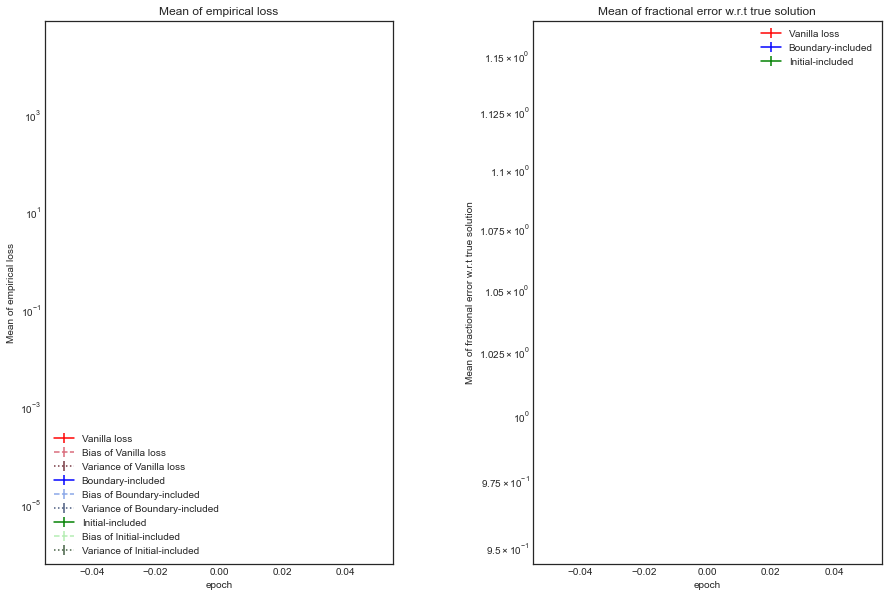

In [22]:
# Plot the error bar of loss and error
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(10)
fig.set_figwidth(15)

ax = fig.add_subplot(1, 2, 1)
ax.errorbar(range(epoch1), mean_loss1_all, yerr=var_loss1_all, label = 'Vanilla loss', color = 'red')
ax.errorbar(range(epoch1), mean_bias1_all, yerr=var_bias1_all, label = 'Bias of Vanilla loss', color = '#d96a7b', linestyle='--')
ax.errorbar(range(epoch1), mean_variance1_all, yerr=var_variance1_all, label = 'Variance of Vanilla loss', color = '#753740', linestyle=':')

ax.errorbar(range(epoch2), mean_loss2_all, yerr=var_loss2_all, label = 'Boundary-included', color = 'blue')
ax.errorbar(range(epoch2), mean_bias2_all, yerr=var_bias2_all, label = 'Bias of Boundary-included', color = '#89a7e8', linestyle='--')
ax.errorbar(range(epoch2), mean_variance2_all, yerr=var_variance2_all, label = 'Variance of Boundary-included', color = '#48597d', linestyle=':')

ax.errorbar(range(epoch3), mean_loss3_all, yerr=var_loss3_all, label = 'Initial-included', color = 'green')
ax.errorbar(range(epoch3), mean_bias3_all, yerr=var_bias3_all, label = 'Bias of Initial-included', color = '#b4edb2', linestyle='--')
ax.errorbar(range(epoch3), mean_variance3_all, yerr=var_variance3_all, label = 'Variance of Initial-included', color = '#435e42', linestyle=':')

ax.set_xlabel('epoch')
ax.set_ylabel('Mean of empirical loss')
ax.set_title("Mean of empirical loss")
ax.set_yscale("log")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.errorbar(range(epoch1), mean_error1_all, yerr=var_error1_all, label = 'Vanilla loss', color = 'red')
ax.errorbar(range(epoch2), mean_error2_all, yerr=var_error2_all, label = 'Boundary-included', color = 'blue')
ax.errorbar(range(epoch3), mean_error3_all, yerr=var_error3_all, label = 'Initial-included', color = 'green')
ax.set_xlabel('epoch')
ax.set_ylabel('Mean of fractional error w.r.t true solution')
ax.set_title("Mean of fractional error w.r.t true solution")
ax.set_yscale("log")
ax.legend()

# save the figure
fig.savefig('images/KdV3_transformation/KdV3_loss_error_errorbar_{}_{}_{}_{}.png'.format(data_size+data_initial_size*2, epoch3, lr, layer_width))


### Plot the heat map Using 100 $\times$ 100 test data

In [23]:
data_u_hat_1 = np.reshape(np.array(u_hat_1_all).mean(axis=0), (321,321))
data_u_hat_2 = np.reshape(np.array(u_hat_2_all).mean(axis=0), (321,321))
data_u_hat_3 = np.reshape(np.array(u_hat_3_all).mean(axis=0), (321,321))
data_u = torch.reshape(u_ex(test_data), (321, 321)).detach().numpy()

# Generate x and y labels
x_axis_labels = []
y_axis_labels = []
for i in range(321):
  if i%(320 / (right_boundary - left_boundary)) == 0:
    y_axis_labels.append(i/(320 / (right_boundary - left_boundary))-(right_boundary - left_boundary)/2)
  # if i%40 == 0:
  #   y_axis_labels.append(i/40 - 4)
  else:
    y_axis_labels.append("")

for i in range(321):
  if i%40 == 0:
    x_axis_labels.append(i/320 - 0.5) 
  else:
    x_axis_labels.append("")

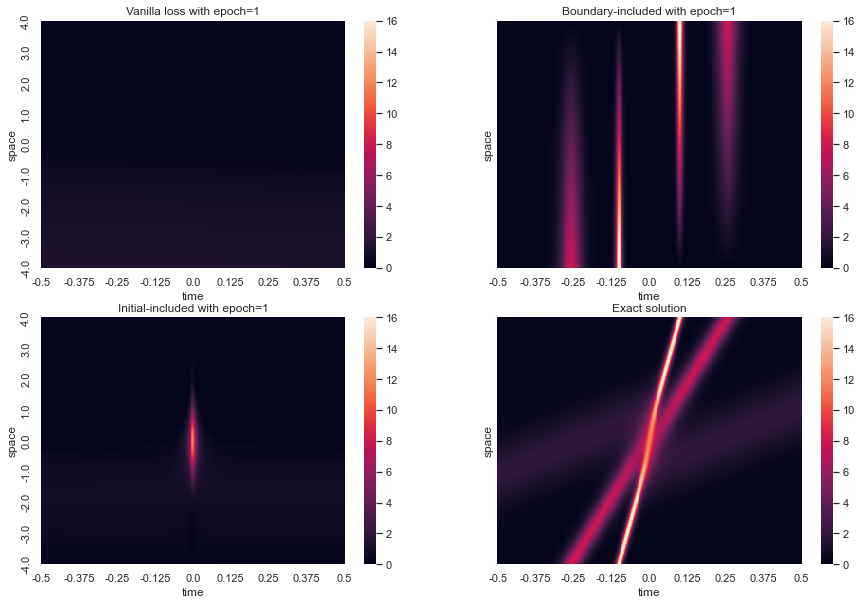

In [24]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,sharey=True)
g1 = sns.heatmap(data_u_hat_1, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cbar=True, vmin=0, vmax=16, ax=ax1)
ax1.set_xlabel('time')
ax1.set_ylabel('space')
# reverse the y axis
ax1.invert_yaxis()
g1.set_title('Vanilla loss with epoch='+str(epoch1))
g2 = sns.heatmap(data_u_hat_2, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cbar=True, vmin=0, vmax=16, ax=ax2)
ax2.set_xlabel('time')
ax2.set_ylabel('space')
ax2.invert_yaxis()
g2.set_title("Boundary-included with epoch="+str(epoch2))
g1 = sns.heatmap(data_u_hat_3, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cbar=True, vmin=0, vmax=16, ax=ax3)
ax3.set_xlabel('time')
ax3.set_ylabel('space')
ax3.invert_yaxis()
g1.set_title('Initial-included with epoch='+str(epoch3))
g2 = sns.heatmap(data_u, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cbar=True, vmin=0, vmax=16, ax=ax4)
ax4.set_xlabel('time')
ax4.set_ylabel('space')
ax4.invert_yaxis()
g2.set_title("Exact solution")

# save the figure   
f.savefig("images/KdV3_transformation/model_transformation_3sol_{}_{}_{}_{}.png".format(epoch1, epoch2, epoch3, layer_width))

In [35]:
data_u.shape

(321, 321)

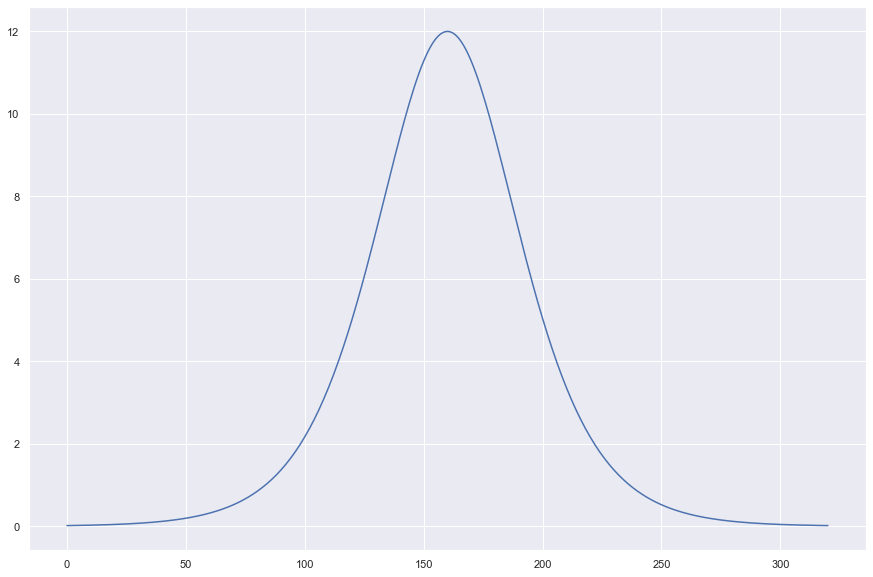

In [37]:
plt.plot(data_u[:, 160])

In [39]:
# three subplots showing data_u[:, 0], data_u[:, 50], data_u[:, 100]
# set plot height and width

# y_axis_labels = []
# for i in range(321):
#     y_axis_labels.append(i/40-4)
    
# fig = plt.figure()
# fig.subplots_adjust(hspace=0.4, wspace=0.2)
# fig.set_figheight(10)
# fig.set_figwidth(5)

# f, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True)
# ax1.plot(y_axis_labels, data_u[:, 0], label = 'Exact solution when t = -1')
# ax1.set_ylabel("u(x, -0.1)")

# ax2.plot(y_axis_labels, data_u[:, 5], label = 'Exact solution when t = 0')
# ax2.set_ylabel("u(x, 0)")

# ax3.plot(y_axis_labels, data_u[:, 10], label = 'Exact solution when t = 1')
# ax3.set_ylabel("u(x, 0.1)")

In [40]:
# Plot all the variance of loss and error
# fig = plt.figure()
# fig.subplots_adjust(hspace=0.4, wspace=0.4)
# fig.set_figheight(8)
# fig.set_figwidth(20)

# ax1 = fig.add_subplot(1, 3, 1)
# ax1.plot(y_axis_labels, data_u[:, 0], label = 'Exact solution when t = -0.1', color = 'black')
# ax1.set_xlabel('x')
# ax1.set_ylabel('u(x, -0.1)')
# ax2.set_ylim(0, 18)
# ax1.legend()

# ax2 = fig.add_subplot(1, 3, 2)
# ax2.plot(y_axis_labels, data_u[:, 5], label = 'Exact solution when t = 0', color = 'black')
# ax2.set_xlabel('x')
# ax2.set_ylabel('u(x, 0)')
# ax2.set_ylim(0, 18)
# # ax2.set_title("Exact 3 solitions solution of KdV equation") 
# ax2.legend()

# ax1 = fig.add_subplot(1, 3, 3)
# ax1.plot(y_axis_labels, data_u[:, 10], label = 'Exact solution when t = 0.1', color = 'black')
# ax1.set_xlabel('x')
# ax1.set_ylabel('u(x, 0.1)')
# ax2.set_ylim(0, 18)
# ax1.legend()

# # save the figure
# fig.savefig('images/KdV3_transformation/KdV3.png')

In [50]:
for i in range(1, 200):
    num = 2*i**2 + 6*i + 1
    if num> 400:
        print(i)
        print(num)
        break


13
417
